In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from astropy.table import Table
from scipy.optimize import curve_fit
from sklearn import mixture

# from astroML.plotting.tools import draw_ellipse
# from xdgmm import XDGMM
# import extreme_deconvolution

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

ftype = '.pdf'

In [4]:
# KEPLER
# file = '1540938945496A.csv'
file = '1543957677477A.csv'
df = pd.read_csv(file)

# df.columns
ok = np.where(np.isfinite(df['parallax']) & # this is basically the same as the TGAS file...
              (df['parallax_error'] < 0.1) &
              (df['ModFlag'] == 1) & 
              (df['ResFlag'] == 1) &
              np.isfinite(df['bp_rp']) & 
              (df['phot_bp_mean_flux_error']/df['phot_bp_mean_flux'] < 0.02) & 
              (df['phot_rp_mean_flux_error']/df['phot_rp_mean_flux'] < 0.02) & 
              (df['phot_g_mean_flux_error']/df['phot_g_mean_flux'] < 0.02) & 
              (df['angDist'] < 0.5) & (df['angDist.1'] < 0.5))[0]
ok.shape # this is most of the true EBs

(2346,)

In [83]:
df.columns

Index(['angDist', 'angDist.1', 'id', 'RA_ICRS', 'DE_ICRS', 'rest', 'b_rest',
       'B_rest', 'rlen', 'ResFlag', 'ModFlag', 'angDist.2', 'ra_epoch2000',
       'dec_epoch2000', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'source_id',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error',
       'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'duplicated_source',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag',
       'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'phot_rp_mean_mag',
       'bp_rp', 'radial_velocity', 'radial_velocity_error', 'rv_nb_transits',
       'teff_val', 'a_g_val', 'e_bp_min_rp_val', 'radius_val', 'lum_val',
       '_RAJ2000', '_DEJ2000', 'KIC', 'Per', 'BJD0', 'Morph', 'SC', 'LC', 'T3',
       'Simbad', '_RA', '_DE', '2MASS', 'RAJ2000', 'DEJ2000', 'errHalfMaj.1',
       'errHalfMin.1', 'errPosAng.1', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag',
       'e_Hmag',

In [5]:
# CATALINA

file = '1540942562357A.csv'
df2 = pd.read_csv(file)

# df2.columns
ok2 = np.where(np.isfinite(df2['parallax']) & # this is basically the same as the TGAS file...
               (df2['parallax_error']/df2['parallax'] < 0.1) &
               (df2['ModFlag'] == 1) & 
               (df2['ResFlag'] == 1) &
               np.isfinite(df2['bp_rp']) & 
               (df2['phot_bp_mean_flux_error']/df2['phot_bp_mean_flux'] < 0.02) & 
               (df2['phot_rp_mean_flux_error']/df2['phot_rp_mean_flux'] < 0.02) & 
               (df2['phot_g_mean_flux_error']/df2['phot_g_mean_flux'] < 0.02) & 
               (df2['angDist'] < 0.5) &
               np.isfinite(df2['Per']))[0]
ok2.shape # this is most of the true EBs

(8863,)

In [133]:
df.columns

Index(['angDist', 'angDist.1', 'id', 'RA_ICRS', 'DE_ICRS', 'rest', 'b_rest',
       'B_rest', 'rlen', 'ResFlag', 'ModFlag', 'angDist.2', 'ra_epoch2000',
       'dec_epoch2000', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'source_id',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error',
       'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'duplicated_source',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag',
       'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'phot_rp_mean_mag',
       'bp_rp', 'radial_velocity', 'radial_velocity_error', 'rv_nb_transits',
       'teff_val', 'a_g_val', 'e_bp_min_rp_val', 'radius_val', 'lum_val',
       '_RAJ2000', '_DEJ2000', 'KIC', 'Per', 'BJD0', 'Morph', 'SC', 'LC', 'T3',
       'Simbad', '_RA', '_DE', '2MASS', 'RAJ2000', 'DEJ2000', 'errHalfMaj.1',
       'errHalfMin.1', 'errPosAng.1', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag',
       'e_Hmag',

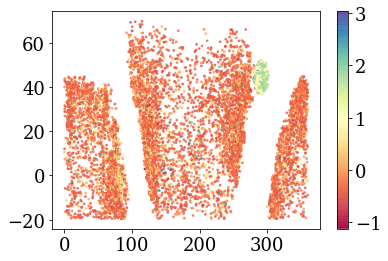

In [6]:
cmap = plt.cm.Spectral

plt.scatter(df2['ra'][ok2], df2['dec'][ok2], c=np.log10(df2['Per'][ok2]), cmap=cmap, alpha=0.75, s=3)

plt.scatter(df['ra'][ok], df['dec'][ok], c=np.log10(df['Per'][ok]), cmap=cmap, alpha=0.75, s=3)

cb = plt.colorbar()

In [7]:
#ASAS-SN
asas = pd.read_csv('asassn-catalog.csv')
asas.columns

okA = np.where((asas['Mean VMag'] < 16) & 
               (asas['Jmag'] - asas['Kmag'] > -0.5) &
               (asas['Jmag'] - asas['Kmag'] < 2) &
               (asas['Classification Probability'] > 0.9) & 
               (asas['Type'] == 'EA') | (asas['Type'] == 'EB') | (asas['Type'] == 'EW'))[0]
print(okA.shape) # this is most of the true EBs

AokA = np.where((asas['Parallax Error'][okA]/asas['Parallax'][okA] < 0.1) &
                np.isfinite(asas['Jmag'][okA]) & 
                np.isfinite(asas['Kmag'][okA]) & 
                (asas['Jmag'][okA] - asas['Kmag'][okA] > -0.5) &
                (asas['Jmag'][okA] - asas['Kmag'][okA] < 2) &
                (asas['Parallax'][okA] > 0) &
                np.isfinite(asas['Parallax'][okA]))[0]
print(AokA.shape)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(61603,)
(43217,)


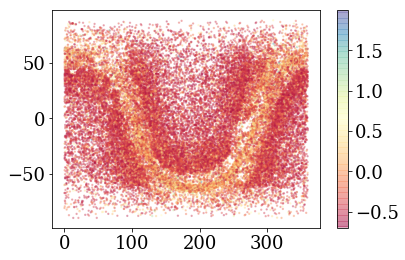

In [8]:
asas.columns

plt.scatter(asas['RAJ2000'][okA[AokA]], asas['DEJ2000'][okA[AokA]], 
            c=np.log10(asas['Period'].values[okA[AokA]].astype('float')),
            s=2, alpha=0.3, cmap=cmap)
cb = plt.colorbar()

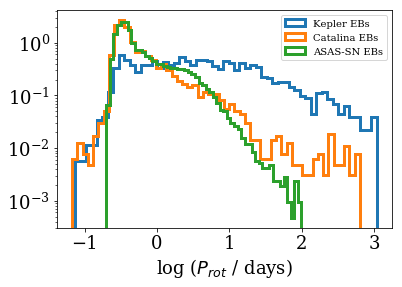

In [9]:
_ = plt.hist(np.log10(df['Per'][ok]), density=True, histtype='step', lw=3, bins=55, label='Kepler EBs')
_ = plt.hist(np.log10(df2['Per'][ok2]), density=True, histtype='step', lw=3, bins=55, label='Catalina EBs')
_ = plt.hist(np.log10(asas['Period'][okA[AokA]].astype('float')), 
             density=True, histtype='step', lw=3, bins=55, label='ASAS-SN EBs')
plt.xlabel('log ($P_{rot}$ / days)')
plt.yscale('log')
plt.legend(fontsize=10)
# plt.savefig('per_hist_compare.png', dpi=300, bbox_inches='tight', pad_inches=0.25)

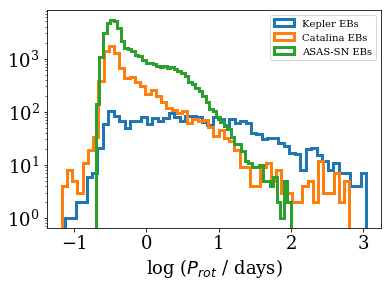

In [10]:
_ = plt.hist(np.log10(df['Per'][ok]), density=False, histtype='step', lw=3, bins=55, label='Kepler EBs')
_ = plt.hist(np.log10(df2['Per'][ok2]), density=False, histtype='step', lw=3, bins=55, label='Catalina EBs')
_ = plt.hist(np.log10(asas['Period'][okA[AokA]].astype('float')), 
             density=False, histtype='step', lw=3, bins=55, label='ASAS-SN EBs')
plt.xlabel('log ($P_{rot}$ / days)')
plt.yscale('log')
plt.legend(fontsize=10)
# plt.savefig('per_hist_compare.png', dpi=300, bbox_inches='tight', pad_inches=0.25)

In [11]:
sum(asas['Period'][okA[AokA]].astype('float') < 7)

42506

In [12]:
sum(asas['Period'][okA[AokA]].astype('float') >= 7)

711

In [13]:
df.columns

Index(['angDist', 'angDist.1', 'id', 'RA_ICRS', 'DE_ICRS', 'rest', 'b_rest',
       'B_rest', 'rlen', 'ResFlag', 'ModFlag', 'angDist.2', 'ra_epoch2000',
       'dec_epoch2000', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'source_id',
       'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error',
       'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'duplicated_source',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag',
       'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_mag',
       'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'phot_rp_mean_mag',
       'bp_rp', 'radial_velocity', 'radial_velocity_error', 'rv_nb_transits',
       'teff_val', 'a_g_val', 'e_bp_min_rp_val', 'radius_val', 'lum_val',
       '_RAJ2000', '_DEJ2000', 'KIC', 'Per', 'BJD0', 'Morph', 'SC', 'LC', 'T3',
       'Simbad', '_RA', '_DE', '2MASS', 'RAJ2000', 'DEJ2000', 'errHalfMaj.1',
       'errHalfMin.1', 'errPosAng.1', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag',
       'e_Hmag',

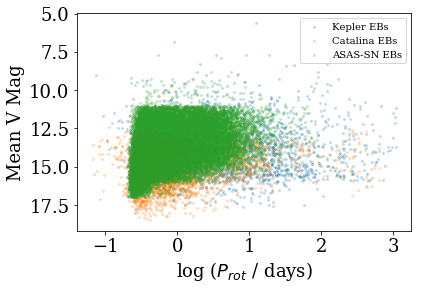

In [14]:
plt.scatter(np.log10(df['Per'][ok]), df['phot_g_mean_mag'][ok], s=4, alpha=0.2, label='Kepler EBs')
plt.scatter(np.log10(df2['Per'][ok2]), df2['<Vmag>'][ok2], 
            s=4, alpha=0.2, label='Catalina EBs')
plt.scatter(np.log10(asas['Period'][okA[AokA]].astype('float')), asas['Mean VMag'][okA[AokA]],
            s=4, alpha=0.2, label='ASAS-SN EBs')

plt.legend(fontsize=10)
plt.xlabel('log ($P_{rot}$ / days)')
plt.ylabel('Mean V Mag')
plt.gca().invert_yaxis()

In [15]:
Plim = 7
mag_lim = [7.5, 15.5]

Klong = np.where((df['Per'][ok] > Plim))[0]

Along = np.where((asas['Period'][okA[AokA]].astype('float') >= Plim) & 
                 (asas['Mean VMag'][okA[AokA]] > mag_lim[0]) & 
                 (asas['Mean VMag'][okA[AokA]] <= mag_lim[1]))[0]
Clong = np.where((df2['Per'][ok2] >= Plim) & 
                 (df2['<Vmag>'][ok2] > mag_lim[0]) & 
                 (df2['<Vmag>'][ok2] <= mag_lim[1]))[0]

print(Klong.size, Along.size, Clong.size)

898 709 290


In [16]:
asas_out_radec = pd.DataFrame(data={'ra':asas['RAJ2000'][okA[AokA]].values[Along], 
                                    'dec':asas['DEJ2000'][okA[AokA]].values[Along]})
asas_out_radec.to_csv('asas_radec.csv', index=False, columns=('ra', 'dec'))


cata_out_radec = pd.DataFrame(data={'ra':df2['ra'][ok2].values[Clong],
                                    'dec':df2['dec'][ok2].values[Clong]})
cata_out_radec.to_csv('cata_radec.csv', index=False, columns=('ra', 'dec'))

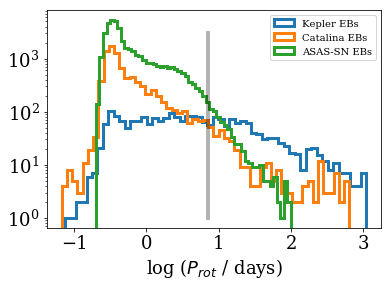

In [17]:
_ = plt.hist(np.log10(df['Per'][ok]), density=False, histtype='step', lw=3, bins=55, label='Kepler EBs')
_ = plt.hist(np.log10(df2['Per'][ok2]), density=False, histtype='step', lw=3, bins=55, label='Catalina EBs')
_ = plt.hist(np.log10(asas['Period'][okA[AokA]].astype('float')), 
             density=False, histtype='step', lw=3, bins=55, label='ASAS-SN EBs')

plt.plot([np.log10(Plim), np.log10(Plim)], [1, 3e3], c='k', lw=4, alpha=0.3)
plt.xlabel('log ($P_{rot}$ / days)')
plt.yscale('log')
plt.legend(fontsize=10)
plt.savefig('per_hist_Plim.png', dpi=300, bbox_inches='tight', pad_inches=0.25)

In [231]:
a_wtv = pd.read_table('wtv-asas_radec.csv', delimiter=',')
c_wtv = pd.read_table('wtv-cata_radec.csv', delimiter=',')

a_wtv.shape

(709, 28)

In [234]:
Along.size

709

In [218]:
# c_wtv

In [20]:
# how many sectors in Cycle 2 are they visible?
A_Nobs = a_wtv.iloc[:, 15:].sum(axis=1)
C_Nobs = c_wtv.iloc[:, 15:].sum(axis=1)

print(sum(A_Nobs > 0), sum(C_Nobs > 0))

259 153


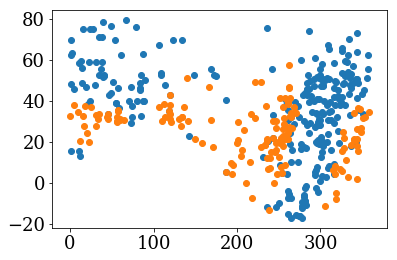

In [21]:
plt.scatter(a_wtv['RA'][A_Nobs > 0], a_wtv['DEC'][A_Nobs > 0])
plt.scatter(c_wtv['RA'][C_Nobs > 0], c_wtv['DEC'][C_Nobs > 0])

In [22]:
2

2

In [60]:
# Kepler EBs that Diana picked for me!
K_D = pd.read_csv('kepler_target_list.csv')

K_D = K_D.drop_duplicates()
K_D.shape

(397, 11)

In [61]:
K_D.columns

Index(['kic', 'period', 'bjd0', 'pdep', 'sdep', 'pwid', 'swid', 'sep', 'morph',
       'ra', 'dec'],
      dtype='object')

## doing it manually....
so when I tried matching my target lists to the TIC with MAST I would get repeat matches (this is not uncommon), but redundant matches would have *vastly different* positions (ra,dec). Thus I could get no sensible match when using an uploaded target list (yikes!)

So... I put it together manually instead, using best-guesses for brightness, and attaching the other catalog IDs for clarity. 

Since our targets are (by construction) Gaia-matched (and Kepler matched for some), they should be easily identified by the TESS GI Office (fingers crossed!)

In [210]:
import ticgen
# tc = ticgen.Star(Gmag=np.array([12.,15]), Jmag=np.array([13,13]))
# tc.TESS_Mag_GJ()

In [353]:
# Kepler targets... need a bit of work
k_targets = pd.merge(K_D, df, left_on='kic', right_on='KIC', how='left')
k_targets = k_targets.drop_duplicates('kic', keep='first')

tc = ticgen.Star(Gmag = k_targets['phot_g_mean_mag'], Jmag = k_targets['Jmag'])
Tmag = tc.TESS_Mag_GJ()

# last final sanity check... oy
OKfinal = np.where(np.isfinite(Tmag) & (Tmag < 15.5))[0]

k_out = pd.DataFrame(data={'TIC':np.empty(len(OKfinal), dtype='str'),
                           'ra':k_targets['ra_x'].values[OKfinal], 
                           'dec':k_targets['dec_x'].values[OKfinal], 
                           'pmra':k_targets['pmra'].values[OKfinal], 
                           'pmdec':k_targets['pmdec'].values[OKfinal],
                           'Tmag':Tmag.values[OKfinal], 
                           'other name':'kic '+k_targets['kic'].astype('str').values[OKfinal]}, index=None)
k_out.shape

(362, 7)

In [354]:
tc = ticgen.Star(Vmag = df2['<Vmag>'][ok2].values[Clong][C_Nobs > 0])
Tmag = tc.TESS_Mag_V()

c_out = pd.DataFrame(data={'TIC':np.empty(len(Tmag), dtype='str'),
                           'ra':df2['ra'][ok2].values[Clong][C_Nobs > 0],
                           'dec':df2['dec'][ok2].values[Clong][C_Nobs > 0],
                           'pmra':df2['pmra'][ok2].values[Clong][C_Nobs > 0],
                           'pmdec':df2['pmdec'][ok2].values[Clong][C_Nobs > 0],
                           'Tmag':Tmag, 
                           'other name':'gaia ' + df2['source_id'][ok2[Clong][C_Nobs > 0]].astype(np.str).values}, 
                     index=None)

c_out.shape

(153, 7)

In [355]:
tc = ticgen.Star(Vmag = asas['Mean VMag'][okA[AokA]].values[Along][A_Nobs > 0])
Tmag = tc.TESS_Mag_V()

a_out = pd.DataFrame(data={'TIC':np.empty(len(Tmag), dtype='str'),
                           'ra':asas['RAJ2000'][okA[AokA]].values[Along][A_Nobs > 0],
                           'dec':asas['DEJ2000'][okA[AokA]].values[Along][A_Nobs > 0],
#                            'pmra':asas['pm_ra'][okA[AokA]].values[Along][A_Nobs > 0],
#                            'pmdec':asas['pm_de'][okA[AokA]].values[Along][A_Nobs > 0],
                           'Tmag':Tmag})
a_out.to_csv('~/Desktop/a_out_tmp.csv') # there's NO pm info... ack! xmatch to Gaia DR2...
a_out.shape


(259, 4)

In [370]:
a_in = pd.read_csv('1552589777970A.csv', na_filter=False)
a_in = a_in.sort_values('phot_g_mean_mag').drop_duplicates('col1', keep='first')

a_out2 = pd.DataFrame(data={'TIC':a_in['TIC'].astype('str'), 
                            'ra':a_in['ra'], 
                            'dec':a_in['dec'],
                            'pmra':a_in['pmra'], 
                            'pmdec':a_in['pmdec'],
                            'Tmag':a_in['Tmag'], 
                            'other name': 'gaia ' + a_in['source_id'].astype('str').values}, index=None)
a_out2.shape

(255, 7)

In [371]:
big_out = pd.concat([k_out, c_out, a_out2], ignore_index=True)
print(big_out.shape)

big_out.to_csv('final_targets.csv', index=False, index_label=False,
               columns=('TIC', 'ra', 'dec', 'pmra', 'pmdec', 'Tmag','other name'))

(770, 7)


In [373]:
# big_out

In [359]:
'''
TIC ID (if available)
Right Ascension (decimal degrees)
Declination (decimal degrees)
Proper motion in Right Ascension (mas yr-1)
Proper motion in Declination (mas yr-1)
TESS mag
''';